In [1]:
using Revise, NeuralNetworkAnalysis, JLD2, DifferentialEquations
const NNA = NeuralNetworkAnalysis
const RA = ReachabilityAnalysis;

In [2]:
controller = NNA.read_nnet_mat("/home/sguadalupe/.julia/dev/NeuralNetworkAnalysis/models/Double-Pendulum/controller_double_pendulum_more_robust.mat", act_key="act_fcns");

In [5]:
const m = 0.5
const L = 0.5
const c = 0.
const g = 1.0
const gL = g/L
const mL = 1/(m*L^2)

function single_pendulum!(dx, x, params, t)
    x1, x2, x3, x4, T1, T2 = x
    ★ = cos(x1 - x2)
    ★₂ = sin.(x1 - x2)
    aux1 = (T1-c*x3)/2L^2*m
    aux2 = (T2-c*x4)/L^2*m
    dx[1] = x3
    dx[2] = x4
    dx[3] = (★ * (x3^2 * ★₂ - ★*((g*sin(x1)/L) - x4^2*★₂/2 + aux1) + g*sin(x2)/L + aux2)) / 2*(★^2/2-1) - (x4^2*★₂)/2 + g*sin(x1)/L + aux1
    dx[4] = ((x3^2 * ★₂ - ★*((g*sin(x1)/L) - x4^2*★₂/2 + aux1) + g*sin(x2)/L + aux2)) / (★^2/2-1)
    dx[5] = zero(x[3]) # T1
    dx[6] = zero(x[3]) # T2
    return dx
end

single_pendulum! (generic function with 1 method)

In [7]:
X₀ = Hyperrectangle(low=[-1, -1, -1, -1.], high=[1.7, 1.7, 1.7, 1.7]);
U₀ = Universe(2)
prob = @ivp(x' = single_pendulum!(x), dim: 3, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:4, :input_vars=>[], :control_vars=>5:6);
plant = ControlledPlant(prob, controller, vars_idx, 0.02);

In [10]:
simulations, controls, inputs = NeuralNetworkAnalysis.simulate(plant, T=.4, trajectories=10);

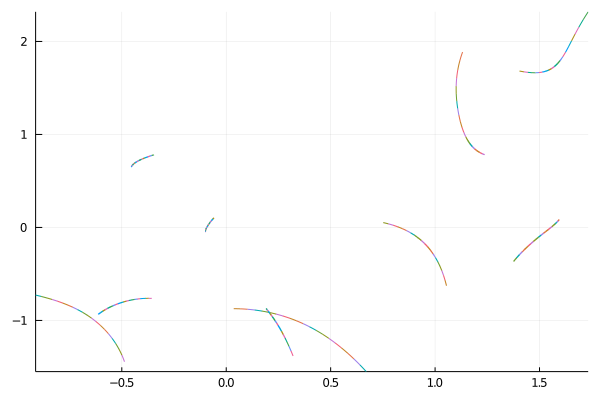

In [11]:
using Plots
fig = plot()
for simulation in simulations
    plot!(fig, simulation, vars=(1, 2), fmt=:png)
end
fig